<a href="https://colab.research.google.com/github/rupeshsah2038/selfPractice/blob/main/Build_a_GAN_model_to_generate_synthetic_images_of_abstract_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

DATA_DIR = '/content/drive/MyDrive/data'
print(os.listdir(DATA_DIR))

['Abstract_gallery', 'archive.zip']


In [ ]:
print(os.listdir(DATA_DIR+'/Abstract_gallery/Abstract_gallery')[:10])

['Abstract_image_2684.jpg', 'Abstract_image_2610.jpg', 'Abstract_image_2651.jpg', 'Abstract_image_2633.jpg', 'Abstract_image_2604.jpg', 'Abstract_image_2631.jpg', 'Abstract_image_2713.jpg', 'Abstract_image_2674.jpg', 'Abstract_image_2670.jpg', 'Abstract_image_2647.jpg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
#batch_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
!pip freeze

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images,nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_xticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

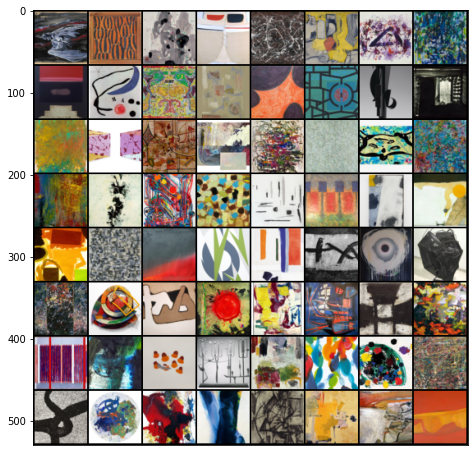

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


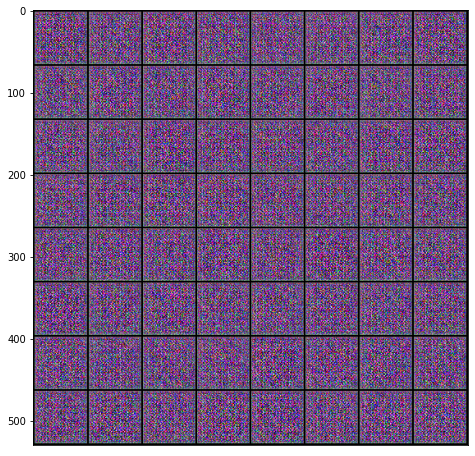

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 200

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 6.3255, loss_d: 0.3304, real_score: 0.7437, fake_score: 0.0066
Saving generated-images-0001.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 6.4748, loss_d: 0.2461, real_score: 0.8961, fake_score: 0.1217
Saving generated-images-0002.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 5.1602, loss_d: 0.4839, real_score: 0.7611, fake_score: 0.1129
Saving generated-images-0003.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 4.7803, loss_d: 0.3520, real_score: 0.8440, fake_score: 0.1509
Saving generated-images-0004.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 2.7458, loss_d: 0.1693, real_score: 0.9482, fake_score: 0.1078
Saving generated-images-0005.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 7.2473, loss_d: 0.1798, real_score: 0.9407, fake_score: 0.1052
Saving generated-images-0006.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 6.2321, loss_d: 0.1193, real_score: 0.9667, fake_score: 0.0796
Saving generated-images-0007.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 4.8217, loss_d: 0.1217, real_score: 0.9159, fake_score: 0.0290
Saving generated-images-0008.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 5.0332, loss_d: 0.0693, real_score: 0.9547, fake_score: 0.0202
Saving generated-images-0009.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 6.4146, loss_d: 0.0430, real_score: 0.9894, fake_score: 0.0317
Saving generated-images-0010.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 6.2857, loss_d: 0.0268, real_score: 0.9885, fake_score: 0.0151
Saving generated-images-0011.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 6.2181, loss_d: 0.0167, real_score: 0.9919, fake_score: 0.0085
Saving generated-images-0012.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 6.6527, loss_d: 0.0278, real_score: 0.9922, fake_score: 0.0197
Saving generated-images-0013.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 6.3527, loss_d: 0.0105, real_score: 0.9970, fake_score: 0.0075
Saving generated-images-0014.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 7.0850, loss_d: 0.0083, real_score: 0.9960, fake_score: 0.0043
Saving generated-images-0015.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 6.7264, loss_d: 0.0099, real_score: 0.9948, fake_score: 0.0047
Saving generated-images-0016.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 6.5249, loss_d: 0.0070, real_score: 0.9967, fake_score: 0.0037
Saving generated-images-0017.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 6.1441, loss_d: 0.0126, real_score: 0.9937, fake_score: 0.0062
Saving generated-images-0018.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 0.1382, loss_d: 1.4071, real_score: 0.3484, fake_score: 0.0000
Saving generated-images-0019.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 3.5820, loss_d: 0.2149, real_score: 0.8805, fake_score: 0.0640
Saving generated-images-0020.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 4.1094, loss_d: 0.4277, real_score: 0.8408, fake_score: 0.1981
Saving generated-images-0021.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 6.5442, loss_d: 0.6880, real_score: 0.8669, fake_score: 0.2647
Saving generated-images-0022.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 4.5715, loss_d: 0.3224, real_score: 0.8739, fake_score: 0.1482
Saving generated-images-0023.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 3.1562, loss_d: 0.4864, real_score: 0.7184, fake_score: 0.0825
Saving generated-images-0024.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 2.2687, loss_d: 0.5031, real_score: 0.6717, fake_score: 0.0183
Saving generated-images-0025.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 6.5844, loss_d: 0.3704, real_score: 0.8619, fake_score: 0.1705
Saving generated-images-0026.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 4.2472, loss_d: 0.5245, real_score: 0.6628, fake_score: 0.0435
Saving generated-images-0027.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 2.3540, loss_d: 0.5533, real_score: 0.6789, fake_score: 0.1137
Saving generated-images-0028.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 4.7090, loss_d: 0.5757, real_score: 0.8865, fake_score: 0.3335
Saving generated-images-0029.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 3.9554, loss_d: 0.1814, real_score: 0.8762, fake_score: 0.0281
Saving generated-images-0030.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 1.0196, loss_d: 0.8730, real_score: 0.5013, fake_score: 0.0226
Saving generated-images-0031.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 2.9448, loss_d: 0.4730, real_score: 0.7729, fake_score: 0.1601
Saving generated-images-0032.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 5.1460, loss_d: 0.4370, real_score: 0.9410, fake_score: 0.2898
Saving generated-images-0033.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 3.9888, loss_d: 0.3694, real_score: 0.9026, fake_score: 0.2135
Saving generated-images-0034.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 2.2822, loss_d: 1.1356, real_score: 0.4048, fake_score: 0.0192
Saving generated-images-0035.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 2.3344, loss_d: 0.4815, real_score: 0.7361, fake_score: 0.1044
Saving generated-images-0036.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 2.9354, loss_d: 0.4742, real_score: 0.9403, fake_score: 0.3089
Saving generated-images-0037.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 3.5531, loss_d: 0.5242, real_score: 0.7689, fake_score: 0.1598
Saving generated-images-0038.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 6.0124, loss_d: 0.4704, real_score: 0.9084, fake_score: 0.2814
Saving generated-images-0039.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 2.5844, loss_d: 0.8557, real_score: 0.5804, fake_score: 0.1437
Saving generated-images-0040.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 2.1578, loss_d: 0.5868, real_score: 0.6225, fake_score: 0.0527
Saving generated-images-0041.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 3.3866, loss_d: 0.8240, real_score: 0.5406, fake_score: 0.0383
Saving generated-images-0042.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 2.2563, loss_d: 0.7977, real_score: 0.6811, fake_score: 0.2919
Saving generated-images-0043.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 4.0274, loss_d: 0.2628, real_score: 0.8382, fake_score: 0.0647
Saving generated-images-0044.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 1.4095, loss_d: 0.9147, real_score: 0.5314, fake_score: 0.1162
Saving generated-images-0045.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 4.6218, loss_d: 0.7036, real_score: 0.9038, fake_score: 0.3975
Saving generated-images-0046.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 2.5218, loss_d: 0.6269, real_score: 0.6339, fake_score: 0.0885
Saving generated-images-0047.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 3.7701, loss_d: 0.3853, real_score: 0.7752, fake_score: 0.0731
Saving generated-images-0048.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 4.0549, loss_d: 0.4331, real_score: 0.9187, fake_score: 0.2689
Saving generated-images-0049.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 4.2811, loss_d: 0.4890, real_score: 0.9195, fake_score: 0.3009
Saving generated-images-0050.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 4.1076, loss_d: 0.5347, real_score: 0.9164, fake_score: 0.3011
Saving generated-images-0051.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 4.0184, loss_d: 0.3941, real_score: 0.7842, fake_score: 0.1068
Saving generated-images-0052.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 6.1797, loss_d: 0.8635, real_score: 0.9528, fake_score: 0.5203
Saving generated-images-0053.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 3.9973, loss_d: 0.7061, real_score: 0.5838, fake_score: 0.0638
Saving generated-images-0054.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 5.4048, loss_d: 0.8025, real_score: 0.8970, fake_score: 0.4248
Saving generated-images-0055.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 1.9031, loss_d: 0.8086, real_score: 0.5396, fake_score: 0.0403
Saving generated-images-0056.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 4.9530, loss_d: 0.7404, real_score: 0.9148, fake_score: 0.4386
Saving generated-images-0057.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 2.1039, loss_d: 0.7883, real_score: 0.5614, fake_score: 0.1001
Saving generated-images-0058.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 3.3269, loss_d: 0.4325, real_score: 0.7664, fake_score: 0.1281
Saving generated-images-0059.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 2.8087, loss_d: 0.2614, real_score: 0.9493, fake_score: 0.1661
Saving generated-images-0060.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 2.6522, loss_d: 0.7897, real_score: 0.5680, fake_score: 0.0993
Saving generated-images-0061.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 2.9104, loss_d: 0.4027, real_score: 0.7999, fake_score: 0.1257
Saving generated-images-0062.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 5.1658, loss_d: 0.5640, real_score: 0.8926, fake_score: 0.3273
Saving generated-images-0063.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 7.2386, loss_d: 0.8553, real_score: 0.9221, fake_score: 0.4818
Saving generated-images-0064.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 2.5937, loss_d: 1.9446, real_score: 0.2073, fake_score: 0.0065
Saving generated-images-0065.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 3.2028, loss_d: 0.9523, real_score: 0.4699, fake_score: 0.0184
Saving generated-images-0066.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 3.3334, loss_d: 1.1392, real_score: 0.3958, fake_score: 0.0042
Saving generated-images-0067.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 6.7279, loss_d: 0.8264, real_score: 0.8875, fake_score: 0.4609
Saving generated-images-0068.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 4.5759, loss_d: 0.5940, real_score: 0.9049, fake_score: 0.3587
Saving generated-images-0069.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 3.4736, loss_d: 0.5409, real_score: 0.7504, fake_score: 0.1860
Saving generated-images-0070.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 4.6999, loss_d: 0.5755, real_score: 0.8440, fake_score: 0.2867
Saving generated-images-0071.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 5.2296, loss_d: 0.8444, real_score: 0.9188, fake_score: 0.4908
Saving generated-images-0072.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 4.8496, loss_d: 0.8792, real_score: 0.7461, fake_score: 0.3979
Saving generated-images-0073.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 2.9609, loss_d: 0.3965, real_score: 0.7797, fake_score: 0.1047
Saving generated-images-0074.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 6.1962, loss_d: 1.1621, real_score: 0.9562, fake_score: 0.5967
Saving generated-images-0075.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 3.8723, loss_d: 0.4546, real_score: 0.8835, fake_score: 0.2610
Saving generated-images-0076.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 2.6243, loss_d: 0.4626, real_score: 0.7209, fake_score: 0.0895
Saving generated-images-0077.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 5.1740, loss_d: 0.5503, real_score: 0.9338, fake_score: 0.3287
Saving generated-images-0078.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 3.8394, loss_d: 0.3977, real_score: 0.8758, fake_score: 0.2076
Saving generated-images-0079.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 2.6488, loss_d: 0.4588, real_score: 0.6831, fake_score: 0.0360
Saving generated-images-0080.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 2.6646, loss_d: 0.7238, real_score: 0.5792, fake_score: 0.0642
Saving generated-images-0081.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 3.5404, loss_d: 0.3160, real_score: 0.8508, fake_score: 0.1267
Saving generated-images-0082.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 5.2828, loss_d: 0.8042, real_score: 0.9127, fake_score: 0.4428
Saving generated-images-0083.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 2.6795, loss_d: 0.7117, real_score: 0.5645, fake_score: 0.0380
Saving generated-images-0084.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 3.6494, loss_d: 0.4304, real_score: 0.8122, fake_score: 0.1719
Saving generated-images-0085.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 1.9884, loss_d: 0.7624, real_score: 0.5613, fake_score: 0.0540
Saving generated-images-0086.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 4.0478, loss_d: 0.3582, real_score: 0.8462, fake_score: 0.1541
Saving generated-images-0087.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 8.8876, loss_d: 1.3537, real_score: 0.9707, fake_score: 0.6838
Saving generated-images-0088.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 3.8781, loss_d: 0.6087, real_score: 0.6584, fake_score: 0.0893
Saving generated-images-0089.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 2.8173, loss_d: 0.2745, real_score: 0.9235, fake_score: 0.1659
Saving generated-images-0090.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 1.4571, loss_d: 1.5428, real_score: 0.2844, fake_score: 0.0079
Saving generated-images-0091.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 3.0650, loss_d: 0.6956, real_score: 0.5569, fake_score: 0.0151
Saving generated-images-0092.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 3.4668, loss_d: 0.3472, real_score: 0.8793, fake_score: 0.1719
Saving generated-images-0093.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 3.3557, loss_d: 0.8113, real_score: 0.5043, fake_score: 0.0128
Saving generated-images-0094.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 8.8615, loss_d: 1.7755, real_score: 0.9833, fake_score: 0.7571
Saving generated-images-0095.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 2.8553, loss_d: 0.4533, real_score: 0.7425, fake_score: 0.1168
Saving generated-images-0096.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 2.3070, loss_d: 0.4446, real_score: 0.7201, fake_score: 0.0659
Saving generated-images-0097.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 4.5473, loss_d: 3.6556, real_score: 0.0375, fake_score: 0.0002
Saving generated-images-0098.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 4.6957, loss_d: 0.3804, real_score: 0.9072, fake_score: 0.2179
Saving generated-images-0099.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 6.6354, loss_d: 0.8228, real_score: 0.9562, fake_score: 0.4970
Saving generated-images-0100.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 2.8566, loss_d: 0.2627, real_score: 0.8958, fake_score: 0.1310
Saving generated-images-0101.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 3.0980, loss_d: 0.2845, real_score: 0.8349, fake_score: 0.0840
Saving generated-images-0102.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 2.8820, loss_d: 0.4520, real_score: 0.7296, fake_score: 0.1049
Saving generated-images-0103.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 4.0013, loss_d: 0.3469, real_score: 0.7754, fake_score: 0.0532
Saving generated-images-0104.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 4.4724, loss_d: 0.3482, real_score: 0.8931, fake_score: 0.1875
Saving generated-images-0105.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 5.7002, loss_d: 0.6366, real_score: 0.9618, fake_score: 0.4163
Saving generated-images-0106.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 1.8275, loss_d: 0.6761, real_score: 0.6060, fake_score: 0.0642
Saving generated-images-0107.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 4.0755, loss_d: 0.2010, real_score: 0.9078, fake_score: 0.0920
Saving generated-images-0108.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 6.0293, loss_d: 0.4226, real_score: 0.9049, fake_score: 0.2498
Saving generated-images-0109.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 5.2350, loss_d: 0.2539, real_score: 0.9660, fake_score: 0.1804
Saving generated-images-0110.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 3.7405, loss_d: 0.3305, real_score: 0.7858, fake_score: 0.0592
Saving generated-images-0111.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 3.0004, loss_d: 0.4729, real_score: 0.7153, fake_score: 0.0889
Saving generated-images-0112.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 3.8469, loss_d: 0.2209, real_score: 0.9676, fake_score: 0.1587
Saving generated-images-0113.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 4.2795, loss_d: 0.2331, real_score: 0.8977, fake_score: 0.1115
Saving generated-images-0114.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 3.3712, loss_d: 0.3296, real_score: 0.7937, fake_score: 0.0672
Saving generated-images-0115.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 2.8185, loss_d: 0.2795, real_score: 0.8587, fake_score: 0.1066
Saving generated-images-0116.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 4.5829, loss_d: 0.2928, real_score: 0.9488, fake_score: 0.2006
Saving generated-images-0117.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 5.7292, loss_d: 0.4967, real_score: 0.9694, fake_score: 0.3334
Saving generated-images-0118.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 4.2814, loss_d: 0.3522, real_score: 0.8932, fake_score: 0.1877
Saving generated-images-0119.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 6.8261, loss_d: 0.4979, real_score: 0.9461, fake_score: 0.3087
Saving generated-images-0120.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 3.8151, loss_d: 0.3584, real_score: 0.8025, fake_score: 0.1028
Saving generated-images-0121.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 5.4758, loss_d: 0.3651, real_score: 0.9425, fake_score: 0.2324
Saving generated-images-0122.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 6.7559, loss_d: 0.4906, real_score: 0.9537, fake_score: 0.3133
Saving generated-images-0123.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 5.0381, loss_d: 0.3824, real_score: 0.8751, fake_score: 0.1990
Saving generated-images-0124.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 3.8091, loss_d: 0.2551, real_score: 0.8593, fake_score: 0.0860
Saving generated-images-0125.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 3.1549, loss_d: 0.2976, real_score: 0.9302, fake_score: 0.1811
Saving generated-images-0126.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 3.9569, loss_d: 0.2505, real_score: 0.8132, fake_score: 0.0235
Saving generated-images-0127.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 4.5428, loss_d: 0.7020, real_score: 0.5577, fake_score: 0.0031
Saving generated-images-0128.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 4.8017, loss_d: 0.4347, real_score: 0.6812, fake_score: 0.0044
Saving generated-images-0129.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 5.2696, loss_d: 0.0997, real_score: 0.9583, fake_score: 0.0528
Saving generated-images-0130.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 4.3245, loss_d: 0.2733, real_score: 0.8880, fake_score: 0.1316
Saving generated-images-0131.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 4.9510, loss_d: 0.2554, real_score: 0.9381, fake_score: 0.1581
Saving generated-images-0132.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 3.1563, loss_d: 0.1504, real_score: 0.9057, fake_score: 0.0463
Saving generated-images-0133.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 4.0248, loss_d: 0.1087, real_score: 0.9564, fake_score: 0.0591
Saving generated-images-0134.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 4.5109, loss_d: 0.3496, real_score: 0.8839, fake_score: 0.1742
Saving generated-images-0135.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 4.7508, loss_d: 0.2519, real_score: 0.8147, fake_score: 0.0152
Saving generated-images-0136.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 4.7041, loss_d: 0.4469, real_score: 0.6870, fake_score: 0.0158
Saving generated-images-0137.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 3.7138, loss_d: 0.2578, real_score: 0.8845, fake_score: 0.1101
Saving generated-images-0138.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 8.0050, loss_d: 0.7632, real_score: 0.9703, fake_score: 0.4661
Saving generated-images-0139.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 3.4191, loss_d: 0.2738, real_score: 0.8228, fake_score: 0.0593
Saving generated-images-0140.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 3.8402, loss_d: 0.2811, real_score: 0.8468, fake_score: 0.0831
Saving generated-images-0141.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 5.9089, loss_d: 0.2156, real_score: 0.9677, fake_score: 0.1488
Saving generated-images-0142.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 4.7796, loss_d: 0.2496, real_score: 0.8435, fake_score: 0.0552
Saving generated-images-0143.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 4.1640, loss_d: 0.2190, real_score: 0.8590, fake_score: 0.0548
Saving generated-images-0144.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 3.3000, loss_d: 0.2121, real_score: 0.8985, fake_score: 0.0888
Saving generated-images-0145.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 2.2387, loss_d: 0.6871, real_score: 0.5487, fake_score: 0.0083
Saving generated-images-0146.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 4.5367, loss_d: 0.2579, real_score: 0.9203, fake_score: 0.1480
Saving generated-images-0147.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 3.0699, loss_d: 0.3219, real_score: 0.8402, fake_score: 0.1160
Saving generated-images-0148.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 5.2044, loss_d: 0.1887, real_score: 0.9825, fake_score: 0.1433
Saving generated-images-0149.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 4.7568, loss_d: 0.1980, real_score: 0.8786, fake_score: 0.0584
Saving generated-images-0150.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 2.8501, loss_d: 0.3215, real_score: 0.8162, fake_score: 0.0870
Saving generated-images-0151.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 2.4745, loss_d: 0.2986, real_score: 0.8108, fake_score: 0.0491
Saving generated-images-0152.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 4.0983, loss_d: 0.3940, real_score: 0.8813, fake_score: 0.2150
Saving generated-images-0153.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 4.1996, loss_d: 0.2423, real_score: 0.8630, fake_score: 0.0707
Saving generated-images-0154.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 4.2621, loss_d: 0.3234, real_score: 0.9309, fake_score: 0.2022
Saving generated-images-0155.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 4.8322, loss_d: 0.2051, real_score: 0.9290, fake_score: 0.1151
Saving generated-images-0156.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 5.9622, loss_d: 0.5796, real_score: 0.9896, fake_score: 0.3449
Saving generated-images-0157.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 3.7620, loss_d: 0.2084, real_score: 0.9453, fake_score: 0.1322
Saving generated-images-0158.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 4.7067, loss_d: 0.4195, real_score: 0.9772, fake_score: 0.3021
Saving generated-images-0159.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 3.5265, loss_d: 0.2187, real_score: 0.8796, fake_score: 0.0741
Saving generated-images-0160.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 2.7526, loss_d: 0.2444, real_score: 0.8617, fake_score: 0.0803
Saving generated-images-0161.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 4.9735, loss_d: 0.3371, real_score: 0.9115, fake_score: 0.1933
Saving generated-images-0162.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 4.9728, loss_d: 0.2783, real_score: 0.9832, fake_score: 0.2041
Saving generated-images-0163.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 4.4013, loss_d: 0.2213, real_score: 0.9548, fake_score: 0.1469
Saving generated-images-0164.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 5.7238, loss_d: 0.4519, real_score: 0.9911, fake_score: 0.3245
Saving generated-images-0165.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 3.8038, loss_d: 0.1584, real_score: 0.9158, fake_score: 0.0615
Saving generated-images-0166.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 3.3186, loss_d: 0.1588, real_score: 0.9051, fake_score: 0.0509
Saving generated-images-0167.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 3.6503, loss_d: 0.2048, real_score: 0.8454, fake_score: 0.0257
Saving generated-images-0168.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 3.9644, loss_d: 0.1128, real_score: 0.9230, fake_score: 0.0268
Saving generated-images-0169.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 4.9654, loss_d: 0.1184, real_score: 0.9046, fake_score: 0.0124
Saving generated-images-0170.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 3.8360, loss_d: 0.1832, real_score: 0.8838, fake_score: 0.0430
Saving generated-images-0171.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 3.8961, loss_d: 0.2347, real_score: 0.9882, fake_score: 0.1785
Saving generated-images-0172.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 4.1604, loss_d: 0.2492, real_score: 0.8843, fake_score: 0.1066
Saving generated-images-0173.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 9.3568, loss_d: 0.7821, real_score: 0.9806, fake_score: 0.4505
Saving generated-images-0174.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 4.2954, loss_d: 0.1327, real_score: 0.9484, fake_score: 0.0706
Saving generated-images-0175.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 4.6725, loss_d: 0.2125, real_score: 0.9713, fake_score: 0.1537
Saving generated-images-0176.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 4.4888, loss_d: 0.1562, real_score: 0.9571, fake_score: 0.1005
Saving generated-images-0177.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 5.4916, loss_d: 0.2159, real_score: 0.9869, fake_score: 0.1692
Saving generated-images-0178.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 5.5532, loss_d: 0.2013, real_score: 0.8415, fake_score: 0.0083
Saving generated-images-0179.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 4.5645, loss_d: 0.1036, real_score: 0.9510, fake_score: 0.0483
Saving generated-images-0180.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 3.0702, loss_d: 0.1901, real_score: 0.8859, fake_score: 0.0578
Saving generated-images-0181.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 4.0254, loss_d: 0.1435, real_score: 0.9271, fake_score: 0.0605
Saving generated-images-0182.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 4.5779, loss_d: 0.0946, real_score: 0.9631, fake_score: 0.0516
Saving generated-images-0183.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 3.3127, loss_d: 0.1665, real_score: 0.8893, fake_score: 0.0401
Saving generated-images-0184.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 5.1662, loss_d: 0.1370, real_score: 0.9776, fake_score: 0.0997
Saving generated-images-0185.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 5.0167, loss_d: 0.1804, real_score: 0.8556, fake_score: 0.0120
Saving generated-images-0186.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 2.5915, loss_d: 0.2624, real_score: 0.8897, fake_score: 0.1005
Saving generated-images-0187.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 4.6008, loss_d: 0.2972, real_score: 0.9769, fake_score: 0.2061
Saving generated-images-0188.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 5.9312, loss_d: 0.3630, real_score: 0.9807, fake_score: 0.2526
Saving generated-images-0189.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 3.4432, loss_d: 0.2071, real_score: 0.8547, fake_score: 0.0377
Saving generated-images-0190.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 1.1376, loss_d: 0.6860, real_score: 0.5713, fake_score: 0.0070
Saving generated-images-0191.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 4.6259, loss_d: 0.1111, real_score: 0.9551, fake_score: 0.0605
Saving generated-images-0192.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 5.0038, loss_d: 0.1940, real_score: 0.9839, fake_score: 0.1360
Saving generated-images-0193.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 6.1316, loss_d: 0.1871, real_score: 0.9847, fake_score: 0.1367
Saving generated-images-0194.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 3.1261, loss_d: 0.1584, real_score: 0.8888, fake_score: 0.0177
Saving generated-images-0195.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 4.8572, loss_d: 0.1002, real_score: 0.9579, fake_score: 0.0521
Saving generated-images-0196.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 3.3475, loss_d: 0.1727, real_score: 0.8970, fake_score: 0.0508
Saving generated-images-0197.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 4.6481, loss_d: 0.1297, real_score: 0.9909, fake_score: 0.1027
Saving generated-images-0198.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 4.3391, loss_d: 0.1871, real_score: 0.9144, fake_score: 0.0860
Saving generated-images-0199.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 3.2159, loss_d: 0.2041, real_score: 0.8623, fake_score: 0.0423
Saving generated-images-0200.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

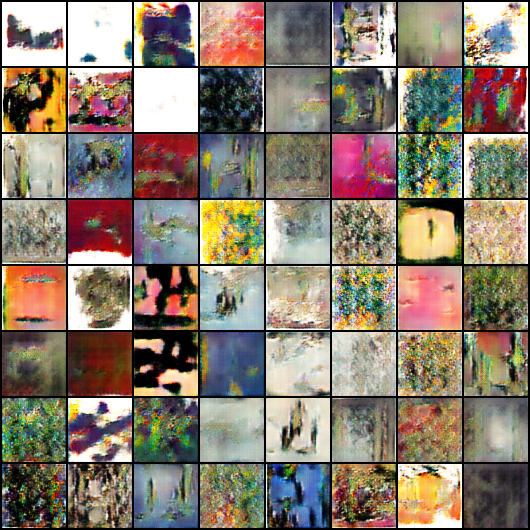

In [ ]:
Image('./generated/generated-images-0200.png')

In [ ]:
# import cv2
# import os

# vid_fname = 'gans_training.avi'

# files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
# files.sort()

# out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
# [out.write(cv2.imread(fname)) for fname in files]
# out.release()

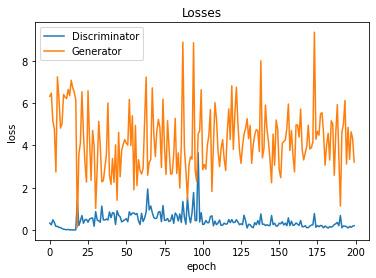

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

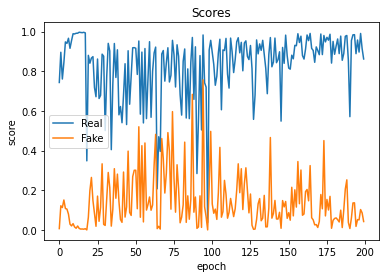

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');